In [1]:
!unzip "/content/caltech-transportation (1).zip" -d "/content/caltech-transportation"


Archive:  /content/caltech-transportation (1).zip
   creating: /content/caltech-transportation/caltech-transportation_test/
   creating: /content/caltech-transportation/caltech-transportation_test/airplanes/
  inflating: /content/caltech-transportation/caltech-transportation_test/airplanes/image_0003.jpg  
  inflating: /content/caltech-transportation/caltech-transportation_test/airplanes/image_0008.jpg  
  inflating: /content/caltech-transportation/caltech-transportation_test/airplanes/image_0011.jpg  
  inflating: /content/caltech-transportation/caltech-transportation_test/airplanes/image_0024.jpg  
  inflating: /content/caltech-transportation/caltech-transportation_test/airplanes/image_0030.jpg  
  inflating: /content/caltech-transportation/caltech-transportation_test/airplanes/image_0031.jpg  
  inflating: /content/caltech-transportation/caltech-transportation_test/airplanes/image_0032.jpg  
  inflating: /content/caltech-transportation/caltech-transportation_test/airplanes/image_003

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense,
    Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
# Βάλε εδώ τα σωστά paths στους φακέλους
TRAIN_DIR = "/content/caltech-transportation/caltech-transportation_train"
TEST_DIR  = "/content/caltech-transportation/caltech-transportation_test"

IMG_SIZE = (128, 128)   # ίδιο με αυτό που χρησιμοποίησες στο MobileNetV2
BATCH_SIZE = 32
EPOCHS = 30             # upper bound, θα κόψει το EarlyStopping


In [4]:
# Data augmentation στο train set
train_datagen = ImageDataGenerator(
    rescale=1./255,          # κανονικοποίηση [0,1]
    rotation_range=15,       # μικρές περιστροφές
    zoom_range=0.2,          # zoom in / out
    width_shift_range=0.1,   # οριζόντιες μετατοπίσεις
    height_shift_range=0.1   # κατακόρυφες μετατοπίσεις
)

# ΜΟΝΟ rescale στο test set (καθαρή αξιολόγηση)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
print("Αριθμός κλάσεων:", num_classes)


Found 1453 images belonging to 5 classes.
Found 366 images belonging to 5 classes.
Αριθμός κλάσεων: 5


In [5]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), activation='relu', padding='same',
                 input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))  # 128 -> 64

# Block 2
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))  # 64 -> 32

# Block 3
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))  # 32 -> 16

# Προαιρετικά (αν θες λίγο πιο δυνατό δίκτυο, μπορείς να προσθέσεις κι άλλο block):
# model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2,2)))  # 16 -> 8

# Flatten + πλήρως συνδεδεμένα
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))            # για regularization

# Τελικό layer για 5 κλάσεις
model.add(Dense(num_classes, activation='softmax'))

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,484,293 (32.37 MB)

 Trainable params: 8,483,845 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping + αποθήκευση καλύτερου μοντέλου
early_stop = EarlyStopping(
    patience=7,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "cnn_scratch_caltech_best.h5",
    save_best_only=True
)


In [7]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7239 - loss: 5.8543

46/46 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7259 - loss: 5.8104 - val_accuracy: 0.2760 - val_loss: 21.9554
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8940 - loss: 1.2647

46/46 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8942 - loss: 1.2668 - val_accuracy: 0.4426 - val_loss: 21.6113
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9006 - loss: 1.0642

46/46 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9007 - loss: 1.0672 - val_accuracy: 0.5027 - val_loss: 17.7708
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9177 - loss: 0.9635 - val_accuracy: 0.4672 - val_loss: 19.7490
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9520 - loss: 0.4211

46/46 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9520 - loss: 0.4206 - val_accuracy: 0.5082 - val_loss: 15.9961
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9459 - loss: 0.5158

46/46 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9457 - loss: 0.5199 - val_accuracy: 0.4973 - val_loss: 13.0971
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9463 - loss: 0.5555

46/46 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9463 - loss: 0.5569 - val_accuracy: 0.5792 - val_loss: 6.9401
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9574 - loss: 0.3851

46/46 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9574 - loss: 0.3861 - val_accuracy: 0.9563 - val_loss: 0.4478
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9434 - loss: 0.4882

46/46 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9435 - loss: 0.4868 - val_accuracy: 0.9645 - val_loss: 0.2648
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9478 - loss: 0.3154 - val_accuracy: 0.9672 - val_loss: 0.3397
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9394 - loss: 0.7023 - val_accuracy: 0.9208 - val_loss: 1.2992
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9575 - loss: 0.3578 - val_accuracy: 0.8880 - val_loss: 2.8382
Epoch 13/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9430 - loss: 0.3596

46/46 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9430 - loss: 0.3599 - val_accuracy: 0.9699 - val_loss: 0.2225
Epoch 14/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9545 - loss: 0.3082 - val_accuracy: 0.9454 - val_loss: 0.2979
Epoch 15/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9490 - loss: 0.2547

46/46 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9489 - loss: 0.2555 - val_accuracy: 0.9727 - val_loss: 0.1581
Epoch 16/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9646 - loss: 0.1160 - val_accuracy: 0.9754 - val_loss: 0.2408
Epoch 17/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9700 - loss: 0.1433

46/46 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9700 - loss: 0.1435 - val_accuracy: 0.9809 - val_loss: 0.1183
Epoch 18/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9688 - loss: 0.1427

46/46 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9688 - loss: 0.1441 - val_accuracy: 0.9891 - val_loss: 0.0730
Epoch 19/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9718 - loss: 0.1510 - val_accuracy: 0.9317 - val_loss: 0.7125
Epoch 20/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9751 - loss: 0.1858 - val_accuracy: 0.9699 - val_loss: 0.2521
Epoch 21/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9745 - loss: 0.1326 - val_accuracy: 0.9699 - val_loss: 0.1537
Epoch 22/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9710 - loss: 0.1315 - val_accuracy: 0.9727 - val_loss: 0.2077
Epoch 23/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9755 - loss: 0.1073 - val_accuracy: 0.9672 - val_loss: 0.2616
Epoch 24/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9730 - loss: 0.1032 - val_accuracy: 0.9645 - val_loss: 0.3205
Epoch 25/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9727 - loss: 0.1940 - val_accuracy: 0.9044 - val_loss: 0.

In [8]:
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy CNN από το μηδέν στο caltech-transportation: {test_acc:.4f}")


Test Accuracy CNN από το μηδέν στο caltech-transportation: 0.9891


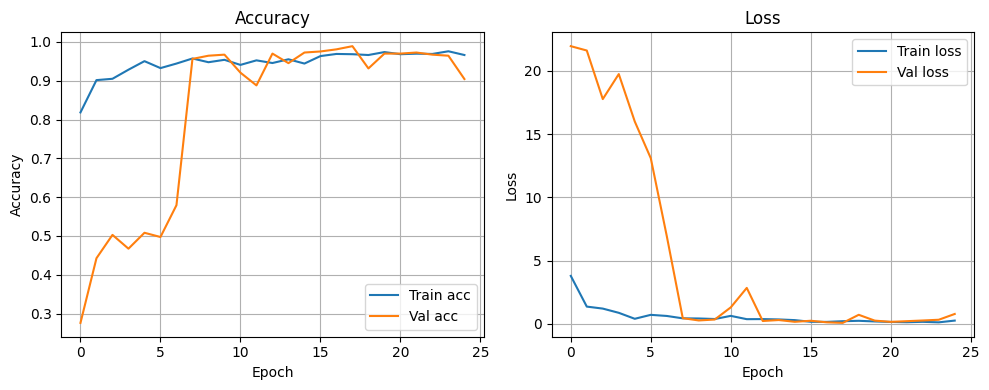

In [9]:
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
